# Named Entity Linking with BERT

## Using BERT embeddings to aid in the task of End-to-End Named Entity Linking

### Task 1 - Read in the annotations and training dataset from AIDA-YAGO2 as well as the Wiki Entity Name/Id dataset

These tab-seperated files will be used to train our model

In [1]:
annotations_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\data\\AIDA-YAGO2-annotations.tsv'

In [2]:
import csv
import re

train_annotations = []
val_annotations = []
test_annotations = []

with open(annotations_file, encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    i = 0
    for row in reader:
        i += 1
        train_annotations.append(row)
        if row == ['-DOCSTART- (947testa CRICKET)']: # first validation document
            #print('validation data starts at index:', i-1)
            val_index = i-1
        if row == ['-DOCSTART- (1163testb SOCCER)']: # first test document
            #print('test data starts at index:', i-1)
            test_index = i-1
    
    val_annotations = train_annotations[val_index: test_index]
    test_annotations = train_annotations[test_index:]
    train_annotations = train_annotations[:val_index]
    
print('train mentions: ', len(train_annotations))
print('validation mentions: ', len(val_annotations))
print('test mentions: ', len(test_annotations))            

train mentions:  25288
validation mentions:  6349
test mentions:  6078


In [3]:
train_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\data\\basic_data\\test_datasets\\AIDA\\aida_train_unquoted.txt'

In [4]:
train_data_raw = []

with open(train_file, encoding='utf-8') as train_tsvfile:
    train_reader = csv.reader(train_tsvfile, delimiter='\t')
    for row in train_reader:
        train_data_raw.append(row)
    
train_data_raw[:490] # just show up to the second document

[['-DOCSTART- (1 EU)'],
 ['EU', 'B', 'EU', '--NME--'],
 ['rejects'],
 ['German',
  'B',
  'German',
  'Germany',
  'http://en.wikipedia.org/wiki/Germany',
  '11867',
  '/m/0345h'],
 ['call'],
 ['to'],
 ['boycott'],
 ['British',
  'B',
  'British',
  'United_Kingdom',
  'http://en.wikipedia.org/wiki/United_Kingdom',
  '31717',
  '/m/07ssc'],
 ['lamb'],
 ['.'],
 [],
 ['Peter', 'B', 'Peter Blackburn', '--NME--'],
 ['Blackburn', 'I', 'Peter Blackburn', '--NME--'],
 [],
 ['BRUSSELS',
  'B',
  'BRUSSELS',
  'Brussels',
  'http://en.wikipedia.org/wiki/Brussels',
  '3708',
  '/m/0177z'],
 ['1996-08-22'],
 [],
 ['The'],
 ['European',
  'B',
  'European Commission',
  'European_Commission',
  'http://en.wikipedia.org/wiki/European_Commission',
  '9974',
  '/m/02q9k'],
 ['Commission',
  'I',
  'European Commission',
  'European_Commission',
  'http://en.wikipedia.org/wiki/European_Commission',
  '9974',
  '/m/02q9k'],
 ['said'],
 ['on'],
 ['Thursday'],
 ['it'],
 ['disagreed'],
 ['with'],
 ['Germa

In [5]:
# create raw validation and test datasets
test_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\data\\basic_data\\test_datasets\\AIDA\\testa_testb_aggregate_unquoted.txt'

validation_data_raw = []
test_data_raw = []

with open(test_file, encoding='utf-8') as test_tsvfile:
    test_reader = csv.reader(test_tsvfile, delimiter='\t')
    for row in test_reader:
        validation_data_raw.append(row)

for i in range(len(validation_data_raw)):
    if validation_data_raw[i] == ['-DOCSTART- (1163testb SOCCER)']: # first test document
        test_index = i
        
test_data_raw = validation_data_raw[test_index:]
validation_data_raw = validation_data_raw[:test_index]

In [6]:
wikiName_id_mapFile = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\data\\basic_data\\wiki_name_id_map.txt'

In [7]:
with open(wikiName_id_mapFile, encoding='utf-8') as wikiMap_tsvfile:
    wikiMap_reader = csv.reader(wikiMap_tsvfile, delimiter='\t')
    wikiName_id_map_dict = {int(row[1]): row[0] for row in wikiMap_reader if row[0][0].isalpha() or row[0][0].isnumeric()}

wikiName_id_map_dict[31717]

'United Kingdom'

### Task 2 - Pre-process the training data

In [8]:
# Import modules that will be used downstream

import json
import pickle
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
import time
import io
import matplotlib.pyplot as plt
from random import shuffle

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

#from sklearn.model_selection import train_test_split

from datetime import datetime

In [9]:
local_bert_path = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\bert'
# local path where the bert module has been cloned from git

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)

In [10]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

In [11]:
# Use the bert model that is cased
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

Create a BERT tokenizer so that words can be tokenized for BERT input

In [12]:
sess = tf.Session()
graph = tf.get_default_graph()

bert_module = hub.Module(bert_url)
tokenization_info = bert_module(signature="tokenization_info", as_dict=True)

vocab_file, do_lower_case = tf.Session().run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])

tokenizer = tokenization.FullTokenizer(
    vocab_file = vocab_file, do_lower_case = do_lower_case
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
# Make sure the tokenizer works
tokenizer_test = tokenizer.tokenize('This tokenizer, is it even working?')
tokenizer_test

['This', 'token', '##izer', ',', 'is', 'it', 'even', 'working', '?']

In [14]:
tokenizer_ids_test = tokenizer.convert_tokens_to_ids(tokenizer_test)
tokenizer_ids_test

[1188, 22559, 17260, 117, 1110, 1122, 1256, 1684, 136]

In [15]:
tokenizer.convert_ids_to_tokens(tokenizer_ids_test)
# seems legit

['This', 'token', '##izer', ',', 'is', 'it', 'even', 'working', '?']

Now the BERT tokenizer can be used to create tokens from the input text that can be used by the BERT model (more on that later).

To simplify things, create a function that creates dictionary objects for document text, NER tags, entity Ids, and wikipedia URLs given row-by-row data (from training or test set)

In [16]:
len(train_data_raw)

218505

In [17]:
def createUtilityDicts(data_rows):

    data_text_dict = {}
    data_nerTag_dict = {}
    data_entityId_dict = {}
    data_wikiUrl_dict = {}

    # set the first DOCSTART of the train data as the dict key
    dict_key = data_rows[0][0]
    # create empty lists for dict values
    text_dict_values = []
    nerTag_dict_values = []
    entityId_dict_values = []
    wikiUrl_dict_values = []

    for row in data_rows[1:]:

        if row == []: #signaling end of sentence
            text_dict_values.append('[SEP]')
            nerTag_dict_values.append('[nerSEP]')
            entityId_dict_values.append('[entSEP]')
            wikiUrl_dict_values.append('[urlSEP]')

        elif len(row[0]) > 9 and row[0][:10] == '-DOCSTART-': # signaling a new document
            data_text_dict.update({dict_key : text_dict_values})
            data_nerTag_dict.update({dict_key : nerTag_dict_values})
            data_entityId_dict.update({dict_key : entityId_dict_values})
            data_wikiUrl_dict.update({dict_key : wikiUrl_dict_values})

            # reset key and value objects
            dict_key = row[0]
            text_dict_values = []
            nerTag_dict_values = []
            entityId_dict_values = []
            wikiUrl_dict_values = []

        elif len(row) > 1: # i.e. there is an entity mention
            for i in range(len(row)): # skip the possibly variable number of wiki names
                if row[i][:4] == 'http' or row[i] == '--NME--':
                    wikiUrl = row[i]                
                    if row[i][:4] == 'http': # only for cases where there is a wiki url
                        entityId = row[i-1] # append the wiki entity name, which precedes the url
                    else:
                        entityId = '--NME--'
            
            for i in range(len(tokenizer.tokenize(row[0]))): 
                text_dict_values.append(tokenizer.tokenize(row[0])[i]) # append all tokenized strings
                nerTag_dict_values.append(row[1]) # append same NER tag for each token
                wikiUrl_dict_values.append(wikiUrl) # append same Wiki URL for each token
                entityId_dict_values.append(entityId) # append same enitity Id for each token

        else: # i.e. there is no entity mention
            for i in range(len(tokenizer.tokenize(row[0]))): # append all tokenized strings
                text_dict_values.append(tokenizer.tokenize(row[0])[i])
                if i == 0:
                    nerTag_dict_values.append('O')
                else:
                    nerTag_dict_values.append('nerX')
                entityId_dict_values.append(None)
                wikiUrl_dict_values.append(None)

    return data_text_dict, data_nerTag_dict, data_entityId_dict, data_wikiUrl_dict

In [18]:
train_text_dict, train_nerTag_dict, train_entityId_dict, train_wikiUrl_dict = createUtilityDicts(train_data_raw)

val_text_dict, val_nerTag_dict, val_entityId_dict, val_wikiUrl_dict = createUtilityDicts(validation_data_raw)

test_text_dict, test_nerTag_dict, test_entityId_dict, test_wikiUrl_dict = createUtilityDicts(test_data_raw)

Check some descriptive statistics on the sentence lengths

In [19]:
sentenceLengths = []

for sentences in train_text_dict.values():
    i = 0
    for token in sentences:
        if token != '[SEP]':
            i += 1
        else:
            sentenceLengths.append(i)
            i = 0

In [20]:
print('sentence mean', np.mean(sentenceLengths))
print('max sentence length', max(sentenceLengths))

sentence mean 16.784703253041968
max sentence length 171


(array([1.389e+03, 9.000e+02, 9.300e+02, 1.160e+03, 1.899e+03, 1.486e+03,
        1.186e+03, 8.170e+02, 7.220e+02, 5.450e+02, 5.910e+02, 5.220e+02,
        5.010e+02, 4.660e+02, 4.350e+02, 3.930e+02, 3.750e+02, 3.210e+02,
        2.780e+02, 2.520e+02, 1.620e+02, 1.610e+02, 1.460e+02, 1.040e+02,
        1.060e+02, 6.400e+01, 5.500e+01, 4.500e+01, 2.200e+01, 1.500e+01,
        1.600e+01, 1.100e+01, 6.000e+00, 3.000e+00, 7.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

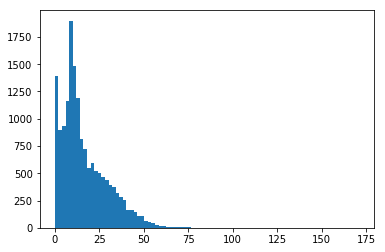

In [21]:
plt.hist(sentenceLengths, bins=85) #bins=170)

## Task 3 - Generate input for the BERT model

Because BERT has a limit of 512 tokens per input, I will try to split documents up into the component sentences, using the max sentence length of 50-75 for training. As can be seen by the histogram above, almost all sentences will fall into this range.

Additionally, for each sentence we will need to add [CLS] and [PAD] tokens

Will need **Sentences, NER Tokens,** and **entity ids**

In [22]:
def createBertTextObjects(text_dict, nerTag_dict, entId_dict, max_sentence_length):
    """
    Add [CLS] and [PAD] tokens to text, NER tag, and entity Id data 
    [PAD] tokens are added until max_sentence_length
    returns bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids
    *Concepts borrowed from BERT_NER_v1
    """
    max_sentence_length -= 1 # to account for Python's zero-based indexing
    
    bert_sentences = []
    bert_ner_tags = []
    bert_entities = []
    bert_mask_ids = []
    
    # start with [CLS] token
    sentence = ['[CLS]'] 
    ner_tags = ['[nerCLS]']
    entity_ids = ['[entCLS]']
    
    for item in text_dict:
    
        for i in range(len(text_dict[item])):

            if text_dict[item][i] == '[SEP]':
                sentence_length = min(max_sentence_length, len(sentence))

                # truncate sequences that are longer than the max_sentence_length
                sentence = sentence[:max_sentence_length-1]
                ner_tags = ner_tags[:max_sentence_length-1]
                entity_ids = entity_ids[:max_sentence_length-1]

                # mask all [PAD] items
                bert_mask_ids.append([1] * (sentence_length + 1) + 
                                     [0] * (max_sentence_length - sentence_length))

                # insert final [SEP] and [PAD] tokens
                sentence += [text_dict[item][i]] + ['[PAD]'] * (max_sentence_length - len(sentence))
                ner_tags += [nerTag_dict[item][i]] + ['[nerPAD]'] * (max_sentence_length - len(ner_tags))
                entity_ids += [entId_dict[item][i]] + ['[entPAD]'] * (max_sentence_length - len(entity_ids))

                bert_sentences.append(sentence)
                bert_ner_tags.append(ner_tags)
                bert_entities.append(entity_ids)

                # restart with [CLS] token
                sentence = ['[CLS]'] 
                ner_tags = ['[nerCLS]']
                entity_ids = ['[entCLS]']
            else:    
                sentence += [text_dict[item][i]]
                ner_tags += [nerTag_dict[item][i]]
                entity_ids += [entId_dict[item][i]]
            
    bert_mask_ids = np.asarray(bert_mask_ids)
            
    return bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids
        

In [23]:
max_sentence_length = 50

bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids = createBertTextObjects(train_text_dict,
                                                                       train_nerTag_dict,
                                                                       train_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

val_sentences, val_ner_tags, val_entities, val_mask_ids = createBertTextObjects(val_text_dict,
                                                                       val_nerTag_dict,
                                                                       val_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

test_sentences, test_ner_tags, test_entities, test_mask_ids = createBertTextObjects(test_text_dict,
                                                                       test_nerTag_dict,
                                                                       test_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

Now we have our BERT inputs as text, we need to modify all inputs to be numerical values

Approach 3 - codes for only relevant tags

In [24]:
def createBertNumObjects3(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to binary 'is-entity' boolean
    bert_nerTag_ids = []
    for item in bert_ner_tags:
        sentenceTags = []
        for tag in item:
            if tag == 'B': # i.e. tag corresponds with an entity
                sentenceTags.append([1])
            elif tag == 'I':
                sentenceTags.append([2])
            else:
                sentenceTags.append([0])
        bert_nerTag_ids.append(sentenceTags)
    
    bert_nerTag_ids = np.asarray(bert_nerTag_ids)
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

In [25]:
bert_sentence_ids, bert_nerTag_ids, bert_seq_ids = createBertNumObjects3(bert_sentences, bert_ner_tags)

val_sentence_ids, val_nerTag_ids, val_seq_ids = createBertNumObjects3(val_sentences, val_ner_tags)

test_sentence_ids, test_nerTag_ids, test_seq_ids = createBertNumObjects3(test_sentences, test_ner_tags)

In [26]:
print(bert_sentence_ids.shape)
print(bert_nerTag_ids.shape) # extra dim of 1 for labels
print(bert_seq_ids.shape)

(16108, 50)
(16108, 50, 1)
(16108, 50)


Get rid of unnecessary documents to free up some memory (going to need it later!)

In [27]:
del train_text_dict
del train_nerTag_dict
del train_entityId_dict
del train_wikiUrl_dict 

del val_text_dict
del val_nerTag_dict
del val_entityId_dict
del val_wikiUrl_dict 

del test_text_dict
del test_nerTag_dict
del test_entityId_dict
del test_wikiUrl_dict 

### Build the BERT model with custom accuracy function!

In [28]:
#tf.reset_default_graph()

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    
def clear_and_set_sess(sess):
    K.clear_session()
    K.set_session(sess)

#sess = tf.Session()
#graph = tf.get_default_graph()

First we will use a custom accuracy function to show how accurate the model performs with regards to 'B' and 'I' tags only

In [29]:
def is_entity_accuracy(y_true, y_pred):
    """
    Calculate accuracy of predicting 'B' and 'I' lables only
    
    y_true: actual NER tag codes with the 'O' value (0) masked
    y_pred: predicted NER tag codes with the 'O' value (0) masked 
    
    returns accuracy measure
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int32)),[-1])
    mask = (y_label > 0) # evaluates to True for all non 'O'/0 labels
    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),[-1,3])
    y_max_pred = tf.cast(tf.math.argmax(input = y_flat_pred, axis=1), tf.int32) # take the max predicted value
    y_pred_masked = tf.boolean_mask(y_max_pred, mask) # mask the predictions as well
    
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_masked, y_label_masked), dtype=tf.float64))


Let's make sure this works the way we want

In [30]:
y_true = tf.constant([1,0,1,0])
y_pred = tf.constant([[0.9,0.05,0.05],[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.9,0.05]])

print(is_entity_accuracy(y_true, y_pred).eval(session=sess))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.5


Now that it is working, we can create the BERT layer

Code borrowed from: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [31]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url = bert_url,
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

Summary metrics for the Tensor board

In [32]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

And a custom adam optimizer that can be adjusted

In [33]:
custom_adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.915, beta_2=0.999, epsilon=None, decay=0.05, amsgrad=False)

In [34]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
# Build model --> sentence inputs -> Bert layer -> Dense layer -> softmax is-entity prediction

in_id = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_token_ids")
in_mask = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_input_masks")
in_segment = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_seq_ids")

bert_inputs = [in_id, in_mask, in_segment]

# Instantiate the custom Bert Layer defined above
bert_output = BertLayer(n_fine_tune_layers=4)(bert_inputs)

# Build the rest of the classifier 
dense = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(bert_output)
dense = tf.keras.layers.Dropout(rate=0.3, name='dropout_1')(dense)
dense = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(dense)
dense = tf.keras.layers.Dropout(rate=0.1, name='dropout_2')(dense)

# prediction layer
ner_pred = tf.keras.layers.Dense(3, activation='softmax', name='entity_identification')(dense)
# take the maximum predicted value
#pred = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(pred, tf.float64)),[-1, 3]), axis=1)


initialize_vars(sess)

ner_model = tf.keras.models.Model(inputs=bert_inputs, outputs=ner_pred)
#ner_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',
#                                                                                is_entity_accuracy])
ner_model.compile(loss='sparse_categorical_crossentropy', optimizer=custom_adam, metrics=['accuracy',
                                                                                is_entity_accuracy])
ner_model.summary()


with graph.as_default():
    K.set_session(sess)
    
    ner_model.fit(
        [bert_sentence_ids, bert_mask_ids, bert_seq_ids], 
        bert_nerTag_ids,
        validation_data=([test_sentence_ids, test_mask_ids, test_seq_ids], 
                         test_nerTag_ids),
        epochs=8,
        batch_size=16
    )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_token_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_seq_ids (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, None, 768)    108931396   bert_token_ids[0][0]             
                                                                 bert_input_masks[0][0]       

In [36]:
def shuffle_data_and_lables(sentence_ids, mask_ids, seq_ids, nerTag_ids):
    if sentence_ids.shape[0] == mask_ids.shape[0] == seq_ids.shape[0] == nerTag_ids.shape[0]:
        shuffle_index = np.random.permutation(sentence_ids.shape[0])
        
        sentence_ids_shuf = sentence_ids[shuffle_index]
        mask_ids_shuf = mask_ids[shuffle_index]
        seq_ids_shuf = seq_ids[shuffle_index]
        nerTag_ids_shuf = nerTag_ids[shuffle_index]
        
        return sentence_ids_shuf, mask_ids_shuf, seq_ids_shuf, nerTag_ids_shuf
        
    else:
        print('Incompatible shapes')

In [37]:
#sess.close()

In [38]:
bert_val_inputs = [val_sentence_ids, val_mask_ids, val_seq_ids]

result = ner_model.predict(
    bert_val_inputs, 
    batch_size=16
)

In [39]:
is_entity_preds = []

# for each sentence in result
for i in range(len(result)):
    # for each token in the sentence
    sentence_preds = []
    for j in range(len(result[i])):
        # append the index of the max predicted value
        index_value = np.where(result[i][j] == np.amax(result[i][j]))[0][0]
        sentence_preds.append(index_value)
    is_entity_preds.append(sentence_preds) 
    
is_entity_preds = np.asarray(is_entity_preds)

In [40]:
bert_test_inputs = [test_sentence_ids, test_mask_ids, test_seq_ids]

test_result = ner_model.predict(
    bert_test_inputs, 
    batch_size=16
)

In [41]:
is_entity_preds_test = []

# for each sentence in result
for i in range(len(test_result)):
    # for each token in the sentence
    sentence_preds = []
    for j in range(len(test_result[i])):
        # append the index of the max predicted value
        index_value = np.where(test_result[i][j] == np.amax(test_result[i][j]))[0][0]
        sentence_preds.append(index_value)
    is_entity_preds_test.append(sentence_preds) 
    
is_entity_preds_test = np.asarray(is_entity_preds_test)

In [42]:
view_result = list(zip(test_sentences[3],is_entity_preds_test[3],test_nerTag_ids[3]))
view_result

[('[CLS]', 0, array([0])),
 ('Japan', 1, array([1])),
 ('began', 0, array([0])),
 ('the', 0, array([0])),
 ('defence', 0, array([0])),
 ('of', 0, array([0])),
 ('their', 0, array([0])),
 ('Asian', 1, array([1])),
 ('Cup', 2, array([2])),
 ('title', 0, array([0])),
 ('with', 0, array([0])),
 ('a', 0, array([0])),
 ('lucky', 0, array([0])),
 ('2', 0, array([0])),
 ('-', 0, array([0])),
 ('1', 0, array([0])),
 ('win', 0, array([0])),
 ('against', 0, array([0])),
 ('Syria', 1, array([1])),
 ('in', 0, array([0])),
 ('a', 0, array([0])),
 ('Group', 0, array([0])),
 ('C', 0, array([0])),
 ('championship', 0, array([0])),
 ('match', 0, array([0])),
 ('on', 0, array([0])),
 ('Friday', 0, array([0])),
 ('.', 0, array([0])),
 ('[SEP]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PAD]', 0, array([0])),
 ('[PA

Output NER prediction arrays

In [44]:
#np.save('C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\is_entity_preds.npy',
#        is_entity_preds)
#np.save('C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\is_entity_preds_test.npy',
#        is_entity_preds_test)

And load when needed again

In [ ]:
#is_entity_preds = np.load('C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\is_entity_preds.npy')
#is_entity_preds_test = np.load('C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\is_entity_preds_test.npy')

## Cheating..or is it?

Using wikipedia search functionality, we can greatly reduce the overhead of storing entity vectors and disambiguate entities from a list of candates!

Given the output from the NER model which identifies the entities, we can then re-assemble the raw text, input that into the wikipedia search, embed the summary for each of the retreived entities, and compute the similarity between the summaries and the mention

In [45]:
import wikipedia
from nltk.tokenize import word_tokenize 
from nltk.tokenize.treebank import TreebankWordDetokenizer

Removing stopwords from the summary improves accuracy

In [46]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

Use Google Universal Sentence Encoder for mention / wikipedia summary embeddings

In [47]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

The below function extracts mentions and the text surrounding the mention

In [48]:
def create_entity_sequences(sequence_length, nerTag_ids, ner_sentences):
    """
    Inputs:
        sequence_length - how many tokens to the left and right of the identified entity
        nerTag_ids - array of NER tag categories, i.e. 0 = 'O', 1 = 'B', 2 = 'I'
        ner_sentences - list of tokenized sentences corresponding to NER tags 
        
    Outputs: for each identified entity, output tokenized text surrounding the entity of length = sequence_length
    """

    mention_sequences = [] # text sub-sequences for each identified mention
    entity_indexes = [] # used to index the original sequence for each identified entity mention
    entity_subseq_indexes = [] # used to index the sub-sequence for each identified mention
    
    # list which gives the entity number within the original sequence
    # required for indexing sub-sequences with multiple entities
    entity_number_list = []
    entity_number = 0
    entity_counter = 0
    for i in range(len(nerTag_ids)):
        if nerTag_ids[i] > [0] and entity_counter == 0:
            entity_number += 1
            entity_counter += 1
            entity_number_list.append(entity_number)
        elif nerTag_ids[i] > [0]:
            entity_number_list.append(entity_number)
        elif nerTag_ids[i] == [0] and entity_counter > 0:
            entity_number_list.append(0)
            entity_counter = 0
        else:
            entity_number_list.append(0)   
    
    zipped_nerTag_ids = list(zip(nerTag_ids, entity_number_list))
    
    entity_counter = 0 # reset entity counter
    total_entities = 0
    
    for i in range(len(nerTag_ids)):
        if nerTag_ids[i] == [0] and entity_counter > 0: # i.e. reached an 'other' tag following identified entities
            ent_index_end = i # mark the ending index of the entity mention
            
            seq_start = max(0, i - entity_counter - sequence_length)
            seq_end = min(i+sequence_length, len(nerTag_ids))

            if seq_start == 0: # i.e. the seqence starts at beginning of sentence, so use extra tokens
                extra_tokens = abs(i - entity_counter - sequence_length)
                if seq_end < len(nerTag_ids):
                    seq_end = min(seq_end + extra_tokens, len(nerTag_ids))

            if seq_end == len(nerTag_ids): # i.e. the sequence ends at the end of the sentence, so use extra tokens
                extra_tokens = sequence_length - (len(nerTag_ids) - i + 1)
                if seq_start > 0:
                    seq_start = max(seq_start - extra_tokens, 0)

            total_entities += 1
            
            mention_sequences.append(ner_sentences[seq_start : seq_end])
            entity_indexes.append([ent_index_start, ent_index_end])
            
            # append the sub-sequence indexing for the entity mention
            entity_counter = 0 # reset entity token counter to use in sub-sequence
            ent_subseq_idx_end = False
            
            for j in range(len(zipped_nerTag_ids[seq_start : seq_end])):
                if zipped_nerTag_ids[seq_start : seq_end][j][1] == total_entities and entity_counter == 0:
                    ent_subseq_idx_start = j
                    ent_subseq_idx_end = True # activate variable for end-index value
                    entity_counter += 1
                        
                if zipped_nerTag_ids[seq_start : seq_end][j][0] == [0] and ent_subseq_idx_end:
                    ent_subseq_idx_end = j
                    entity_subseq_indexes.append([ent_subseq_idx_start,ent_subseq_idx_end])
                    entity_counter = 0 # reset entity token counter again for full sequence
                    ent_subseq_idx_end = False # switch end-index variable back off


            entity_counter = 0 # reset entity token counter again for full sequence

        elif nerTag_ids[i] > [0]: # i.e. identified the start of an entity token sequence
            if entity_counter == 0: 
                ent_index_start = i # mark the starting index of the entity mention
            
            entity_counter += 1
            
    return mention_sequences, entity_indexes, entity_subseq_indexes


In [ ]:
mention_sequences_list = []
entity_index_list = []
entity_subseq_list = []

for i in range(len(val_sentences)):
    mention_sequences, ent_idx, ent_subseq_idx = create_entity_sequences(sequence_length = 5, 
                                                                     nerTag_ids = is_entity_preds[i], 
                                                                     ner_sentences = val_sentences[i])

    mention_sequences_list.extend(mention_sequences)
    entity_index_list.append(ent_idx)
    entity_subseq_list.extend(ent_subseq_idx)

In [ ]:
initialize_vars(sess)

mention = mention_sequences_list[7][entity_subseq_list[7][0] : entity_subseq_list[7][1]]
mention = ' '.join(mention).replace(' ##', '')

mention_embedding = embed([mention]).eval(session=sess)

entity_summaries = []
candidates = wikipedia.search(mention,2)

for item in candidates:
    summary = wikipedia.summary(item)[:200]
    tokenized_summary = word_tokenize(summary)
    tokenized_summary = [token for token in tokenized_summary if token not in stopwords]
    summary = TreebankWordDetokenizer().detokenize(tokenized_summary)
    entity_summaries.append(summary)
    
entity_embeddings = embed(entity_summaries).eval(session=sess)


With the mention and candidate entities embedded, we can compute the cosine similarity

In [49]:
def find_entity_nn(mention_arr, entities_arr, entity_list, k=1):
    """
    Inputs:
        mention_arr - a vector embedding of mention text
        entities_arr - an array of entity summary embeddings
        entity_list - the list of text entities
        k - how many nearest neighbors to output
        
    Returns:
        a list of the entity and it's cosine similarity value to the mention embedding
    """
    
    cos_sim_list = []
    for i in range(len(entities_arr)):
        cos_sim = np.dot(mention_arr, entities_arr[i]) / (np.linalg.norm(mention_arr) * np.linalg.norm(entities_arr[i]))
        cos_sim_list.append(cos_sim[0])
        #cos_sim_list.append(cos_sim)

    top_index = np.argsort(np.asarray(cos_sim_list))[-k:]

    result = []
    for item in top_index:
        result.append((entity_list[item], cos_sim_list[item]))
        
    return result

Baseline measure 1 - Use entity mention text to link the entity 

In [63]:
baseline_1 = []
    
for sentence in val_sentences:
    sentence_tokens = []
    for token in sentence:
        if token == '[CLS]':
            sentence_tokens.append('[entCLS]')
        elif token == '[SEP]':
            sentence_tokens.append('[entSEP]')
        elif token == '[PAD]':
            sentence_tokens.append('[entPAD]')
        else:
            sentence_tokens.append(None)
    baseline_1.append(sentence_tokens)
    
mention_sequences_list = []
entity_index_list = []
entity_subseq_list = []
    
for i in range(len(val_sentences)):
    mention_sequences, ent_idx, ent_subseq_idx = create_entity_sequences(sequence_length = 3, 
                                                                     nerTag_ids = val_nerTag_ids[i], 
                                                                     ner_sentences = val_sentences[i])

    mention_sequences_list.extend(mention_sequences)
    entity_index_list.append(ent_idx)
    entity_subseq_list.extend(ent_subseq_idx)

mention_list = []
    
for i in range(len(mention_sequences_list)):
    mention = mention_sequences_list[i][entity_subseq_list[i][0] : entity_subseq_list[i][1]]
    mention = '_'.join(mention).replace('_##', '')
    mention_list.append(mention)
    
candidate_index = 0

for i in range(len(baseline_1)):
    # use the original sentence indexes to replace values with the top candidate
    for index in entity_index_list[i]:
        # for each index, replace the output_entities_list value with the top candidate value
        for k in range(index[0],index[1]):
            baseline_1[i][k] = mention_list[candidate_index]
        #print(round((i*100)/len(baseline_1),2),'% complete')            
        # move to the next top candidate
        candidate_index += 1

In [64]:
evaluation_entities = val_entities

accuracy = 0
total = 0

for i in range(len(baseline_1)):
    for j in range(len(baseline_1[i])):
        if baseline_1[i][j] not in ['[entCLS]','[entSEP]','[entPAD]']: # ignore CLS, SEP, and PAD tokens
            if baseline_1[i][j] == evaluation_entities[i][j]:
                accuracy += 1
            total += 1
        
print('EL accuracy:', round(accuracy/total,5))

EL accuracy: 0.82326


Now we can create a function that wraps this all up nicely

In [50]:
def entity_linking(nerTag_ids, ner_sentences, mention_sequence_length = 5, wikipedia_summaries=2, wiki_chars=200): 
    """
    Inputs:
        nerTag_ids - array of NER tag categories, i.e. 0 = 'O', 1 = 'B', 2 = 'I'
        ner_sentences - list of tokenized sentences corresponding to NER tags 
        mention_sequence_length - int value for how many tokens to the left and right of the identified entity
        wikipedia_summaries - an int for how many wikipedia entity summaries should be pulled
        wiki_chars - number of characters to embed from the Wikipedia summaries
        
    Outputs:
        List of entities to be compared with annotated entities
    """
    # create placeholder entity list
    output_entity_list = []
    
    for sentence in ner_sentences:
        sentence_tokens = []
        for token in sentence:
            if token == '[CLS]':
                sentence_tokens.append('[entCLS]')
            elif token == '[SEP]':
                sentence_tokens.append('[entSEP]')
            elif token == '[PAD]':
                sentence_tokens.append('[entPAD]')
            else:
                sentence_tokens.append(None)
        output_entity_list.append(sentence_tokens)
    
    # Extract text sequences containing identified entities
    mention_sequences_list = []
    entity_index_list = []
    entity_subseq_list = []

    for i in range(len(ner_sentences)):
        mention_sequences, ent_idx, ent_subseq_idx = create_entity_sequences(sequence_length = mention_sequence_length, 
                                                                         nerTag_ids = nerTag_ids[i], 
                                                                         ner_sentences = ner_sentences[i])

        mention_sequences_list.extend(mention_sequences)
        entity_index_list.append(ent_idx)
        entity_subseq_list.extend(ent_subseq_idx)
    
    # For each identified entity, pull a list of possible candidates using wikipedia.search
    top_candidates_list = []
    
    for i in range(len(mention_sequences_list)):
        mention = mention_sequences_list[i][entity_subseq_list[i][0] : entity_subseq_list[i][1]]
        mention = ' '.join(mention).replace(' ##', '')
        mention_embedding = embed(mention_sequences_list[i]).eval(session=sess)
        
        candidates = wikipedia.search(mention, wikipedia_summaries) # how many to search given as input parameter

        entity_summaries = []

        for item in candidates:
            try:
                summary = wikipedia.summary(item)[:wiki_chars]

            except:
                summary = None

            if summary:
                tokenized_summary = word_tokenize(summary)
                tokenized_summary = [token for token in tokenized_summary if token not in stopwords]
                summary = TreebankWordDetokenizer().detokenize(tokenized_summary)
                entity_summaries.append(summary)

        if len(entity_summaries) > 0:
            entity_embeddings = embed(entity_summaries).eval(session=sess)

            top_candidate = find_entity_nn(mention_embedding, entity_embeddings, candidates, 1)[0][0]

            top_candidates_list.append(top_candidate)
            print(round((i*100)/len(mention_sequences_list),2),'% complete')

        else:
            top_candidates_list.append('--NME--')
            print(round((i*100)/len(mention_sequences_list),2),'% complete')
            
    print('\n\n')
    print('Top Candidate List Complete')
            
    # add top candidates to placeholder list
    print('\n\n')
    print('Beginning output_entity_list')
    candidate_index = 0
    for i in range(len(output_entity_list)):
        # use the original sentence indexes to replace values with the top candidate
        for index in entity_index_list[i]:
            # for each index, replace the output_entities_list value with the top candidate value
            for k in range(index[0],index[1]):
                output_entity_list[i][k] = top_candidates_list[candidate_index]
            print(round((i*100)/len(output_entity_list),2),'% complete')            
            # move to the next top candidate
            candidate_index += 1
            
    
    return output_entity_list
    
                  

**Warning**

This takes ~6-8 hours to run

In [69]:
#initialize_vars(sess)

output_entity_list = entity_linking(is_entity_preds_test, 
                                      test_sentences, 
                                      mention_sequence_length = 3, 
                                      wikipedia_summaries=2,
                                      wiki_chars=25)

0.0 % complete
2.0 % complete
4.0 % complete
6.0 % complete
8.0 % complete
10.0 % complete
12.0 % complete
14.0 % complete
16.0 % complete
18.0 % complete
20.0 % complete
22.0 % complete
24.0 % complete
26.0 % complete
28.0 % complete
30.0 % complete
32.0 % complete
34.0 % complete
36.0 % complete
38.0 % complete
40.0 % complete
42.0 % complete
44.0 % complete
46.0 % complete
48.0 % complete
50.0 % complete
52.0 % complete
54.0 % complete
56.0 % complete
58.0 % complete
60.0 % complete
62.0 % complete
64.0 % complete
66.0 % complete
68.0 % complete
70.0 % complete
72.0 % complete
74.0 % complete
76.0 % complete
78.0 % complete
80.0 % complete
82.0 % complete
84.0 % complete
86.0 % complete
88.0 % complete
90.0 % complete
92.0 % complete
94.0 % complete
96.0 % complete
98.0 % complete



Top Candidate List Complete



Beginning output_entity_list
2.0 % complete
2.0 % complete
2.0 % complete
2.0 % complete
2.0 % complete
2.0 % complete
4.0 % complete
8.0 % complete
10.0 % complete
10.0 %

In [70]:
evaluation_entities = test_entities

accuracy = 0
total = 0

for i in range(len(output_entity_list)):
    for j in range(len(output_entity_list[i])):
        if output_entity_list[i][j] not in ['[entCLS]','[entSEP]','[entPAD]']: # ignore CLS, SEP, and PAD tokens
            if output_entity_list[i][j] == evaluation_entities[i][j]:
                accuracy += 1
            total += 1
        
print('EL accuracy:', round(accuracy/total,5))

EL accuracy: 0.84875


# For the purposes of this project, code ends here

# appendix for entity embeddings in BERT/USE

## Task 4 - Create entity embeddings for Wikipedia entities

### This will help the task of Candidate Generation for the model

Using the wikiName_id_map_dict created earlier, scrape wikipedia articles for text descriptions of the entity

In [ ]:
import wikipedia

In [ ]:
print(wikipedia.WikipediaPage(title = 'Brussels').summary[:512])

In [ ]:
entity_summary_ids_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\entity_summary_ids.npy'
entity_mask_ids_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\entity_mask_ids.npy'
entity_seq_ids_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\entity_seq_ids.npy'
output_entities_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\output_entities.data'
entities_ext_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\entity_ext.data'

### For loading pre-created entity objects

Below cell can be run to open files

In [ ]:
entity_summary_ids = np.load(entity_summary_ids_filepath)
entity_mask_ids = np.load(entity_mask_ids_filepath)
entity_seq_ids = np.load(entity_seq_ids_filepath)

with open(output_entities_filepath, 'rb') as file_in:
    output_entities = pickle.load(file_in)

with open(entities_ext_filepath, 'rb') as file_in:
    entities_ext = pickle.load(file_in)    

In [ ]:
entity_summary_ids.shape

### Once run, skip to "Embed the entities as vectors using Google Universal Sentence Encoder"

### For loading entity and summaries the first time

In [ ]:
#start_time = time.time()

#wikiId_summaryTokens_dict = {}
#i = 0
#for wikiId in wikiName_id_map_dict:

#    if i > 100:
#        break # control
#    i += 1
#    try:
#        summary = wikipedia.summary(wikiName_id_map_dict[wikiId])
#    except:
#        summary = None
        
#    if summary:
#        dict_value = tokenizer.tokenize(summary)[:512] # max_length
#        dict_value = tokenizer.convert_tokens_to_ids(dict_value)
#        wikiId_summaryTokens_dict.update({wikiId: dict_value})

#timing = time.time() - start_time
#print('100 Wikipedia page summaries executed in',round(timing,2),'seconds')

Given that the summary extraction takes so long, I'm going to cheat a bit to encode the entities as BERT 768 dimensional pooled vectors

In [ ]:
entities = []

for item in train_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
for item in validation_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities    
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
for item in test_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
entities = list(set(entities)) # unique entities only

# replace unicode characters
for i in range(len(entities)):
    if '\\u' in entities[i]:
        entities[i] = entities[i].encode().decode('unicode_escape')

In [ ]:
entities[:20]

Now let's add some noise to our entities

In [ ]:
#entities_ext = []
#start_time = time.time()
#i = 1

#for entity in entities:
#    ent_start_time = time.time()
#    print(entity, ' - ', str(round((i/len(entities)*100),3))+'%')
#    entities_ext.extend(wikipedia.search(entity,results=5))
#    timing = time.time() - ent_start_time
#    print('\t', round(timing,2),'seconds')
#    i += 1

#timing = time.time() - start_time

#print('\n\n')
#print('Created noise for',len(entities),'entities. Executed in', round((timing/60),2),'minutes \n\n')

Next we can tokenize the wiki summary for each entity

In [ ]:
def createBertEntityObjects(entity_list, num_entities = 10, max_length=512):
    """
    Given an list of entities, output numerical bert token ids, mask ids, and sequence ids
    Last output is the text list of each entity that is contained in the vectors
    Used for input into the bert entity vectors
    Starts at 10 entities for output
    """
    
    start_time = time.time()
    
    max_length -= 2 # account for CLS and SEP tokens
    
    entity_summary_ids = []
    entity_mask_ids = []
    entity_seq_ids = []
    output_entities = []
    
    i = 1

    for item in entity_list[:num_entities]:
        # give run time information as this step can take a long time
        item_start_time = time.time()
        print(item, ' - ', str(round((i/num_entities*100),3))+'%')
        try:
            summary = tokenizer.tokenize(wikipedia.summary(item))[:max_length] 
        except:
            summary = None

        if summary:
            num_pads = max_length - len(summary) 
            masks = ([1] * (len(summary)+2)) + ([0] * num_pads) # no need to account for CLS and SEP pads
            summary = ['[CLS]'] + summary + ['[SEP]'] + (['[PAD]'] * num_pads)
            summary = tokenizer.convert_tokens_to_ids(summary)

            output_entities.append(item)
            entity_summary_ids.append(np.asarray(summary))
            entity_mask_ids.append(np.asarray(masks))
            entity_seq_ids.append(np.asarray([1] * (max_length + 2))) # no need to account for CLS and SEP pads
        
        timing = time.time() - item_start_time
        print('\t', round(timing,2),'seconds')
        i += 1

    entity_summary_ids = np.asarray(entity_summary_ids)
    entity_mask_ids = np.asarray(entity_mask_ids)
    entity_seq_ids = np.asarray(entity_seq_ids)

    timing = time.time() - start_time
    print('\n\n')
    
    print(len(entity_summary_ids), 'Wikipedia page summaries executed in',round((timing/60),2),'minutes')
    print('entity_summary_ids shape:', entity_summary_ids.shape)
    print('entity_mask_ids shape:', entity_mask_ids.shape)
    print('entity_seq_ids shape:', entity_seq_ids.shape)
    print('Number of text entities:',len(output_entities))
    
    return entity_summary_ids, entity_mask_ids, entity_seq_ids, output_entities

In [ ]:
len(entities_ext)

**Running this with all extended entities takes ~22 hours**

In [ ]:
#num_entities = len(entities_ext)
#max_length = 300

#entity_summary_ids, entity_mask_ids, entity_seq_ids, output_entities = createBertEntityObjects(entities_ext, 
#                                                                              num_entities = num_entities,
#                                                                              max_length = max_length)

Now write the file out so that it can be easily used later on

**Only needed when first creating entity objects**

In [ ]:
# output ndarray objects
#entity_files = [entity_summary_ids_filepath, 
#                entity_mask_ids_filepath, 
#                entity_seq_ids_filepath]
#
#entity_data = [entity_summary_ids, 
#                entity_mask_ids, 
#                entity_seq_ids]
#
#for i in range(len(entity_files)):
#    np.save(entity_files[i], entity_data[i])
#    
#
# output list objects
#entity_files = [output_entities_filepath,
#                entities_ext_filepath]
#
#entity_data = [output_entities,
#                entities_ext]
#
#for i in range(len(entity_files)):
#    with open(entity_files[i], 'wb') as file_out:
#        pickle.dump(entity_data[i], file_out)

**Note - BERT entity embeddings did not work as well as expected, therefore, the Google USE will be used to compute vector similarity between wikipedia summaries and the corresponding mention for the task of entity disambiguation and linking**

**Unfortunately this means we have to un-tokenize the text..**

### Embed the entities as vectors using Google Universal Sentence Encoder

In [ ]:
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
entity_summaries = []
for item in test_entity_summary_ids:
    summary = ' '.join(tokenizer.convert_ids_to_tokens(item)).replace(' ##','')
    entity_summaries.append(summary)

In [ ]:
entity_embeddings = embed(entity_summaries)

In [ ]:
#initialize_vars(sess)

entity_embeddings_arr = entity_embeddings.eval(session=sess)

### Embed the mentions as vectors as well

Example sentence

In [ ]:
list(zip(val_sentences[2],val_ner_tags[2],val_nerTag_ids[2]))

**Phil Simmons** is the entity we need to match in this example

First we need a helper function to output a sequence around the entity

In [ ]:
def create_entity_sequences(sequence_length, nerTag_ids, ner_sentences):
    """
    Inputs:
        sequence_length - how many tokens to the left and right of the identified entity
        nerTag_ids - array of NER tag categories, i.e. 0 = 'O', 1 = 'B', 2 = 'I'
        ner_sentences - list of tokenized sentences corresponding to NER tags 
        
    Outputs: for each identified entity, output tokenized text surrounding the entity of length = sequence_length
    """

    mention_sequences = [] # text sub-sequences for each identified mention
    entity_indexes = [] # used to index the original sequence for each identified entity mention
    entity_subseq_indexes = [] # used to index the sub-sequence for each identified mention
    
    # list which gives the entity number within the original sequence
    # required for indexing sub-sequences with multiple entities
    entity_number_list = []
    entity_number = 0
    entity_counter = 0
    for i in range(len(nerTag_ids)):
        if nerTag_ids[i] > [0] and entity_counter == 0:
            entity_number += 1
            entity_counter += 1
            entity_number_list.append(entity_number)
        elif nerTag_ids[i] > [0]:
            entity_number_list.append(entity_number)
        elif nerTag_ids[i] == [0] and entity_counter > 0:
            entity_number_list.append(0)
            entity_counter = 0
        else:
            entity_number_list.append(0)   
    
    zipped_nerTag_ids = list(zip(nerTag_ids, entity_number_list))
    
    entity_counter = 0 # reset entity counter
    total_entities = 0
    
    for i in range(len(nerTag_ids)):
        if nerTag_ids[i] == [0] and entity_counter > 0: # i.e. reached an 'other' tag following identified entities
            ent_index_end = i # mark the ending index of the entity mention
            
            seq_start = max(0, i - entity_counter - sequence_length)
            seq_end = min(i+sequence_length, len(nerTag_ids))

            if seq_start == 0: # i.e. the seqence starts at beginning of sentence, so use extra tokens
                extra_tokens = abs(i - entity_counter - sequence_length)
                if seq_end < len(nerTag_ids):
                    seq_end = min(seq_end + extra_tokens, len(nerTag_ids))

            if seq_end == len(nerTag_ids): # i.e. the sequence ends at the end of the sentence, so use extra tokens
                extra_tokens = sequence_length - (len(nerTag_ids) - i + 1)
                if seq_start > 0:
                    seq_start = max(seq_start - extra_tokens, 0)

            total_entities += 1
            
            mention_sequences.append(ner_sentences[seq_start : seq_end])
            entity_indexes.append([ent_index_start, ent_index_end])
            
            # append the sub-sequence indexing for the entity mention
            entity_counter = 0 # reset entity token counter to use in sub-sequence
            ent_subseq_idx_end = False
            
            for j in range(len(zipped_nerTag_ids[seq_start : seq_end])):
                if zipped_nerTag_ids[seq_start : seq_end][j][1] == total_entities and entity_counter == 0:
                    ent_subseq_idx_start = j
                    ent_subseq_idx_end = True # activate variable for end-index value
                    entity_counter += 1
                        
                if zipped_nerTag_ids[seq_start : seq_end][j][0] == [0] and ent_subseq_idx_end:
                    ent_subseq_idx_end = j
                    entity_subseq_indexes.append([ent_subseq_idx_start,ent_subseq_idx_end])
                    entity_counter = 0 # reset entity token counter again for full sequence
                    ent_subseq_idx_end = False # switch end-index variable back off


            entity_counter = 0 # reset entity token counter again for full sequence

        elif nerTag_ids[i] > [0]: # i.e. identified the start of an entity token sequence
            if entity_counter == 0: 
                ent_index_start = i # mark the starting index of the entity mention
            
            entity_counter += 1
            
    return mention_sequences, entity_indexes, entity_subseq_indexes


In [ ]:
mention_sequences, ent_idx, ent_subseq_idx = create_entity_sequences(sequence_length = 5, 
                                                                     nerTag_ids = val_nerTag_ids[2], 
                                                                     ner_sentences = val_sentences[2])

In [ ]:
[mention_sequences[1]]

In [ ]:
ent_subseq_idx[1]

In [ ]:
len(mention_sequences) == len(ent_idx) == len(ent_subseq_idx)

In [ ]:
mention_text = []
for item in [mention_sequences[1]]:
    summary = ' '.join(item).replace(' ##','')
    mention_text.append(summary)

In [ ]:
mention_embeddings = embed(mention_text)

In [ ]:
mention_embeddings_arr = mention_embeddings.eval(session=sess)

### Compute cosine similarity between wikipedia summary embeddings and sentence sequences

In [ ]:
def find_entity_nn(mention_arr, entities_arr, entity_list, k=1):
    """
    Inputs:
        mention_arr - a vector embedding of mention text
        entities_arr - an array of entity summary embeddings
        entity_list - the list of text entities
        k - how many nearest neighbors to output
        
    Returns:
        a list of the entity and it's cosine similarity value to the mention embedding
    """
    
    cos_sim_list = []
    for i in range(len(entities_arr)):
        cos_sim = np.dot(mention_arr, entities_arr[i]) / (np.linalg.norm(mention_arr) * np.linalg.norm(entities_arr[i]))
        cos_sim_list.append(cos_sim[0])
        #cos_sim_list.append(cos_sim)

    top_index = np.argsort(np.asarray(cos_sim_list))[-k:]

    result = []
    for item in top_index:
        result.append((entity_list[item], cos_sim_list[item]))
        
    return result

In [ ]:
find_entity_nn(mention_embeddings_arr, entity_embeddings_arr, test_output_entities, 5)

In [ ]:
wikipedia.summary('Lendl Simmons')

**Remove english stopwords for increased accuracy?**

In [ ]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
# remove bert tokens as well
#stopwords.add('[cls]') 
#stopwords.add('[sep]')
#stopwords.add('[pad]')

In [ ]:
entity_summaries = []
for item in test_entity_summary_ids:
    tokenized_summary = tokenizer.convert_ids_to_tokens(item)
    tokenized_summary = [token for token in tokenized_summary if token.lower() not in stopwords]
    summary = ' '.join(tokenized_summary).replace(' ##','')
    entity_summaries.append(summary)

In [ ]:
entity_embeddings = embed(entity_summaries)

In [ ]:
entity_embeddings_arr = entity_embeddings.eval(session=sess)

In [ ]:
find_entity_nn(mention_embeddings_arr, entity_embeddings_arr, test_output_entities, 2)

Getting closer!

# Putting it all together

Let's start with a baseline..

The simplest thing to do might be to just take the entity mention and slap it on the back of a wikipedia article. Let's try that

In [ ]:
for i in range(len(entity_summaries)):
    if entity_summaries[i] == 'London':
        print(i)

Now let's find the most similar wikipedia summary vectors

In [ ]:
entity_summaries = []
for item in entity_summary_ids:
    tokenized_summary = tokenizer.convert_ids_to_tokens(item)
    tokenized_summary = [token for token in tokenized_summary if token.lower() not in stopwords]
    summary = ' '.join(tokenized_summary).replace(' ##','')
    entity_summaries.append(summary)

In [ ]:
#initialize_vars(sess)

In [ ]:
mention_sequences_list = []
entity_index_list = []
entity_subseq_list = []

for i in range(len(val_sentences)):
    mention_sequences, ent_idx, ent_subseq_idx = create_entity_sequences(sequence_length = 5, 
                                                                     nerTag_ids = val_nerTag_ids[i], 
                                                                     ner_sentences = val_sentences[i])
    
    mention_sequences_list.extend(mention_sequences)
    entity_index_list.extend(ent_idx)
    entity_subseq_list.extend(ent_subseq_idx)

In [ ]:
mention_text = []
for item in mention_sequences_list:
    summary = ' '.join(item).replace(' ##','')
    mention_text.append(summary)

In [ ]:
mention_embeddings_arr = embed(mention_text[0:10]).eval(session=sess)

Unfortunately, the memory space required to store all entity summaries as a single array is too much. So we can split it up

In [ ]:
def find_entity_nn1(mention_arr, entities_arr, entity_list, k=1):
    """
    Inputs:
        mention_arr - a vector embedding of mention text
        entities_arr - an array of entity summary embeddings
        entity_list - the list of text entities
        k - how many nearest neighbors to output
        
    Returns:
        a list of the entity and it's cosine similarity value to the mention embedding
    """
    
    cos_sim_list = []
    for i in range(len(entities_arr)):
        cos_sim = np.dot(mention_arr, entities_arr[i]) / (np.linalg.norm(mention_arr) * np.linalg.norm(entities_arr[i]))
        #cos_sim_list.append(cos_sim[0])
        cos_sim_list.append(cos_sim)

    top_index = np.argsort(np.asarray(cos_sim_list))[-k:]

    result = []
    for item in top_index:
        result.append((entity_list[item], cos_sim_list[item]))
        
    result = np.asarray(result)
    return result

In [ ]:
split_indexes = [item for item in range(0,57501,2500)]

start_time = time.time()

mention_similarities = []

for i in range(len(split_indexes)-1):
    item_start_time = time.time()
    
    entity_embeddings = embed(entity_summaries[split_indexes[i] : split_indexes[i+1]])
    output_entities_split = output_entities[split_indexes[i] : split_indexes[i+1]]
    entity_embeddings_arr = entity_embeddings.eval(session=sess)
    split_mention_similarities = []
    
    for vector in mention_embeddings_arr:
        split_mention_similarities.append(find_entity_nn1(vector, 
                                                         entity_embeddings_arr, 
                                                         output_entities_split, 3)) # top 3 candidates
        
    mention_similarities.append(np.asarray(split_mention_similarities))
    split_time = time.time()
    timing = time.time() - item_start_time
    print(round((100 * (i+1)) / len(split_indexes),2),'% complete. Executed in',round(timing,2),'seconds.')

mention_similarities = np.asarray(mention_similarities)    
timing = time.time() - start_time

print('Completed in', round((timing/60),2),'minutes.')
    

4 mentions - Completed in 3.91 minutes.

In [ ]:
mention_text[0:4]

In [ ]:
for item in mention_similarities:
    print(item[3])

In [ ]:
mention_text[3]

Not as accurate for the work..which brings about the final section